In [4]:
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from discretize import TensorMesh
from SimPEG import utils
from simulFFT import simulFFT, transform_distribution, truncate_grf
# from emrecharge.colocation import find_locations_in_distance, find_closest_locations

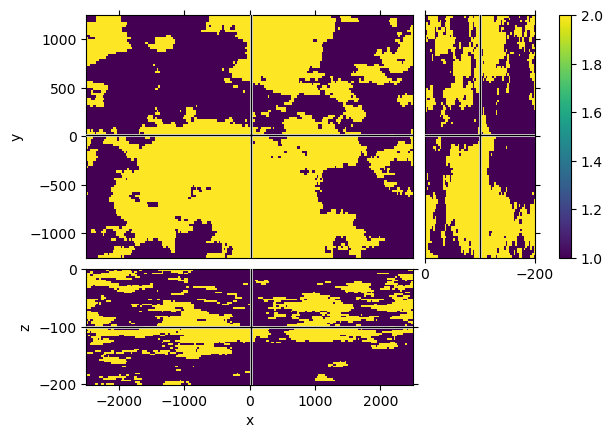

In [58]:
import random
random.seed(1)
RHO = simulFFT(100, 200, 67, 20, 40, 'Exponential', 40, 80, 20)
rho = RHO.flatten(order='F')
ROCK = np.log10(truncate_grf(RHO, proportions=(0.64, 0.36), vals=(1, 2)))
# ROCK = np.log10(truncate_grf(RHO, proportions=(0.5, 0.5), vals=(1, 2)))
rock = ROCK.flatten(order='F')
nx, ny, nz = RHO.shape
dx = 25. 
dy = 25. 
dz = 3.
hx = np.ones(nx) * dx 
hy = np.ones(ny) * dy 
hz = np.ones(nz) * dz 
# CCN 
mesh = TensorMesh([hx, hy, hz], x0='CCN')
mesh.plot_3d_slicer(utils.mkvc(rock))

In [51]:
print ((rock==1).sum() / mesh.nC)
print ((rock==2).sum() / mesh.nC)

0.6400007462686567
0.3599992537313433


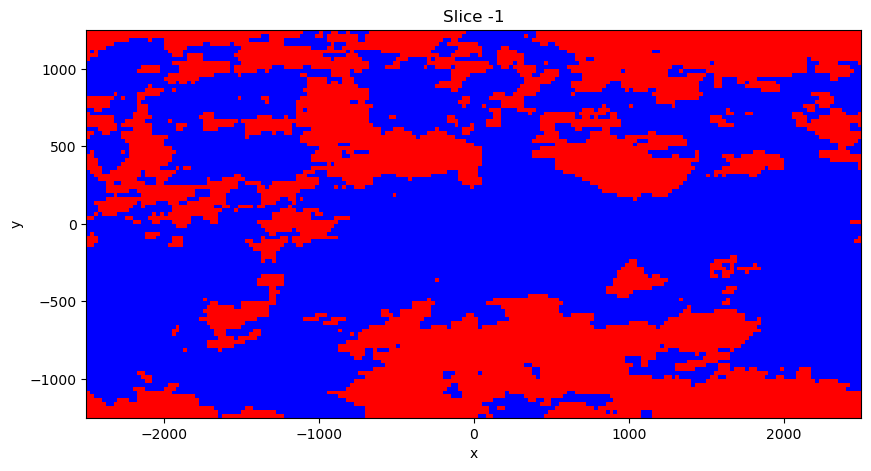

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
mesh.plot_slice(rock, pcolor_opts={'cmap':'bwr'}, ax=ax, ind=-1)
# ax.plot(source_locations[:,0], source_locations[:,1], 'rx')
ax.set_aspect(1)

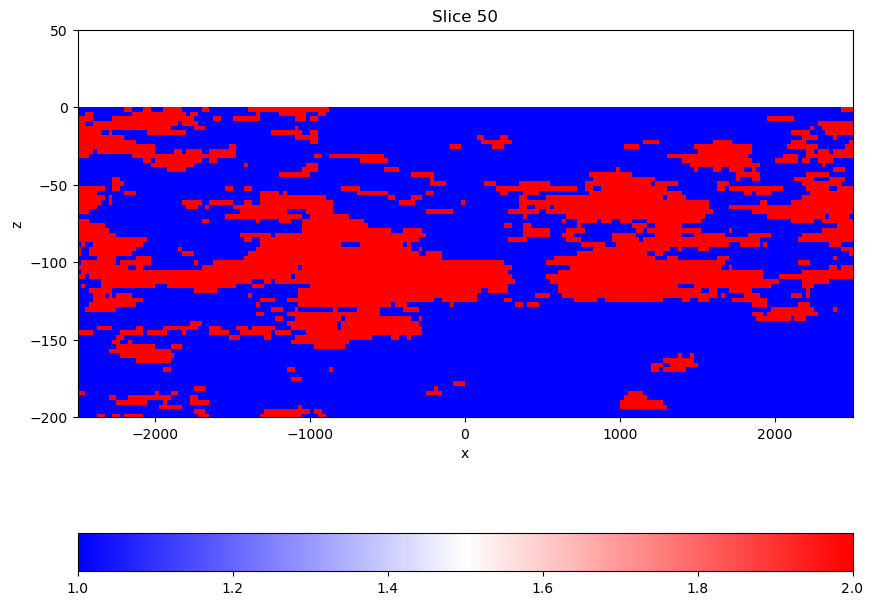

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
out = mesh.plot_slice(rock, pcolor_opts={'cmap':'bwr'}, ax=ax, normal='Y')
# ax.plot(source_locations[:,0], source_locations[:,2], 'rx', ms=3)
ax.set_ylim(-200, 50)
ax.set_aspect(10)
plt.colorbar(out[0], ax=ax, orientation='horizontal')

In [59]:
# pd.DataFrame(data=np.c_[mesh.gridCC, utils.mkvc(rock_ti)], columns=['X', 'Y', 'Z', 'ROCK']).to_csv("rock.csv", index=False)

In [62]:
xy = utils.ndgrid(mesh.cell_centers_x, mesh.cell_centers_y)

In [81]:
import random

def generate_proportional_random_integers(proportions, values, size):
    # Create a cumulative distribution
    cumulative_distribution = []
    cumulative_sum = 0
    for p in proportions:
        cumulative_sum += p
        cumulative_distribution.append(cumulative_sum)
    
    # Normalize cumulative distribution to 1
    cumulative_distribution = [x / cumulative_sum for x in cumulative_distribution]
    
    # Generate random integers based on the cumulative distribution
    random_integers = []
    for _ in range(size):
        r = random.random()
        for i, threshold in enumerate(cumulative_distribution):
            if r < threshold:
                random_integers.append(values[i])
                break

    return np.array(random_integers)

# Example usage
proportions = [0.2, 0.5, 0.3]  # Proportions for 1, 2, and 3
values = [1, 2, 3]  # The integers to generate
size = 100  # Number of integers to generate

random_integers = generate_proportional_random_integers(proportions, values, size)
print(random_integers)


[2 2 2 2 1 2 2 1 1 1 3 1 3 1 2 1 1 3 1 3 3 1 2 3 3 2 2 2 2 2 2 3 2 2 2 2 2
 1 3 1 1 3 2 1 3 1 3 3 2 2 1 2 2 3 2 2 2 2 2 3 2 3 1 2 3 2 3 2 2 2 2 2 3 3
 2 3 1 2 1 2 2 3 1 3 3 2 2 2 2 2 3 1 3 1 2 2 2 2 2 2]


In [172]:
inds_clay_dominated = rock== 1.
inds_sand_dominated = rock == 2.
cd_proportion = 0.2
sd_proportion = 0.9
# for clay-dominated 
# 1 - sand 30%
# 2 - clay 70%

# for sand-dominated 
# 1 - sand 70%
# 2 - clay 30%

In [173]:
n_cd = inds_clay_dominated.sum()
n_sd = inds_sand_dominated.sum()

In [174]:
cd_proportion

0.2

In [175]:
1-sd_proportion

0.09999999999999998

In [176]:
sed_inds_cd = generate_proportional_random_integers([1-cd_proportion, cd_proportion], [1, 2], n_cd)

In [177]:
sed_inds_sd = generate_proportional_random_integers([1-sd_proportion, sd_proportion], [1, 2], n_sd)

In [178]:
(sed_inds_cd == 2).sum() / len(sed_inds_cd)

0.19971991637136619

In [179]:
(sed_inds_cd == 1).sum() / len(sed_inds_cd)

0.8002800836286338

In [180]:
(sed_inds_sd == 1).sum() / len(sed_inds_sd)

0.10045833428344586

In [181]:
(sed_inds_sd == 2).sum() / len(sed_inds_sd)

0.8995416657165541

In [182]:
sed_3d = np.zeros_like(rock)
sed_3d[inds_clay_dominated] = sed_inds_cd
sed_3d[inds_sand_dominated] = sed_inds_sd

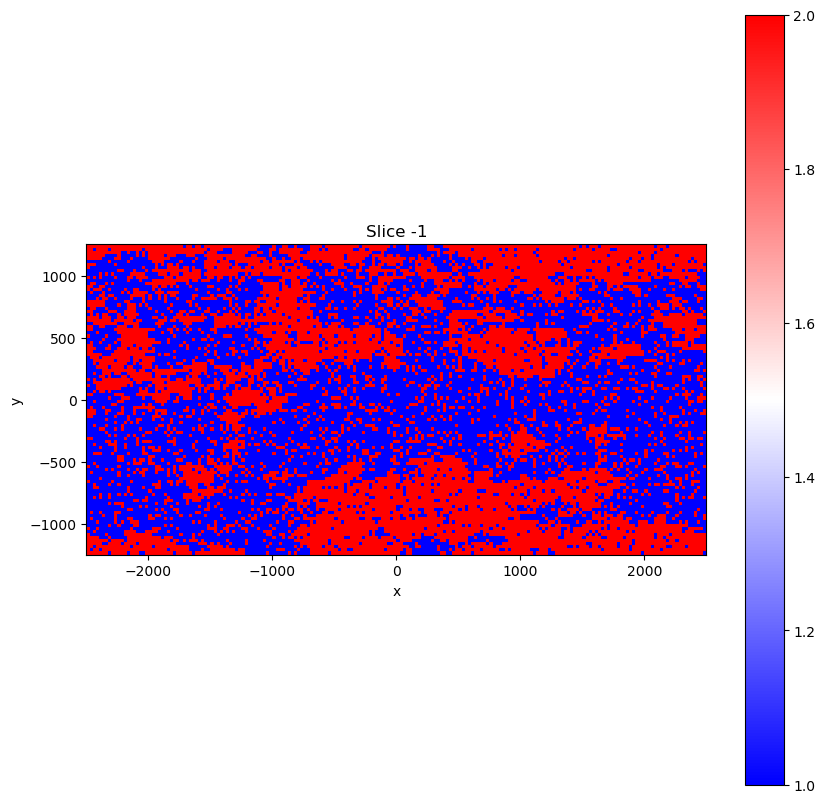

In [183]:
fig, ax = plt.subplots(figsize=(10, 10))
out = mesh.plot_slice(sed_3d, pcolor_opts={'cmap':'bwr'}, ax=ax, ind=-1)
# ax.plot(source_locations[:,0], source_locations[:,1], 'rx')
ax.set_aspect(1)
plt.colorbar(out[0])

In [185]:
# mesh.plot_3d_slicer(rho)

In [186]:
# from scipy.ndimage import gaussian_filter
# WATER = simulFFT(50, 100, 1, 30, 10, 'Exponential', 30, 30, 1)
# water = utils.mkvc(WATER)
# WATER_SMOOTH = gaussian_filter(WATER, sigma=10, order=0)
# out = plt.pcolormesh(WATER_SMOOTH)
# plt.colorbar(out)
# gse_inds = utils.surface2ind_topo(mesh, np.c_[xy, -water], method='linear')

In [187]:
import numpy as np
rho_fine_dominated_mean = 15.
rho_coarse_dominated_mean = 30.
log_rho_std = 1.2
rho_fine_dominated = np.exp(np.random.normal(np.log(rho_fine_dominated_mean), np.log(log_rho_std), 1000))
rho_coarse_dominated = np.exp(np.random.normal(np.log(rho_coarse_dominated_mean), np.log(log_rho_std), 1000))

In [188]:
import matplotlib
matplotlib.rcParams['font.size'] = 13
matplotlib.rcParams['pcolor.shading'] = 'auto'
from matplotlib.ticker import FormatStrFormatter

Text(0.5, 0, 'Resistivity ($\\Omega$)m')

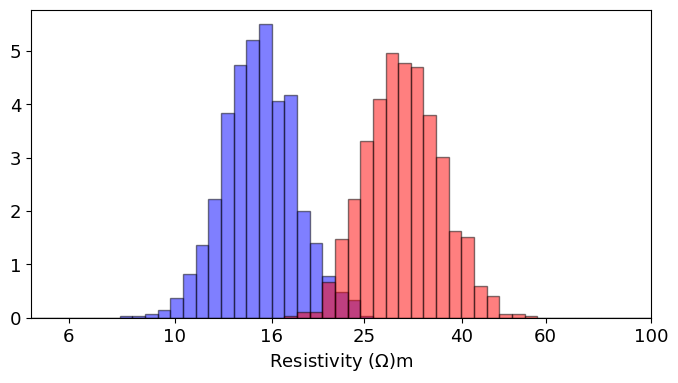

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
bins = np.linspace(np.log10(5), 2, 50)
ax.hist(np.log10(rho_fine_dominated), density=True, bins=bins, edgecolor='k', alpha=0.5, color='b')
ax.hist(np.log10(rho_coarse_dominated), density=True, bins=bins, edgecolor='k', alpha=0.5, color='r')
xticks = np.log10(np.r_[6, 10, 16, 25, 40, 60, 100])
ax.set_xticks(xticks)
ax.set_xticklabels([("%.0f")%(10**(x)) for x in xticks])
ax.set_xlim(np.log10(5), 2)
ax.set_xlabel("Resistivity ($\Omega$)m")

In [195]:
ind_clay_dominated = rock==1
ind_sand_dominated = rock==2

In [196]:
ind_fine_dominated.sum()

857601

In [197]:
ind_coarse_dominated.sum()

482399

In [198]:
rho_sample = np.zeros(mesh.nC)
rho_sample[ind_clay_dominated] = np.exp(np.random.normal(np.log(rho_fine_dominated_mean), np.log(log_rho_std), ind_clay_dominated.sum()))
rho_sample[ind_sand_dominated] = np.exp(np.random.normal(np.log(rho_coarse_dominated_mean), np.log(log_rho_std), ind_sand_dominated.sum()))

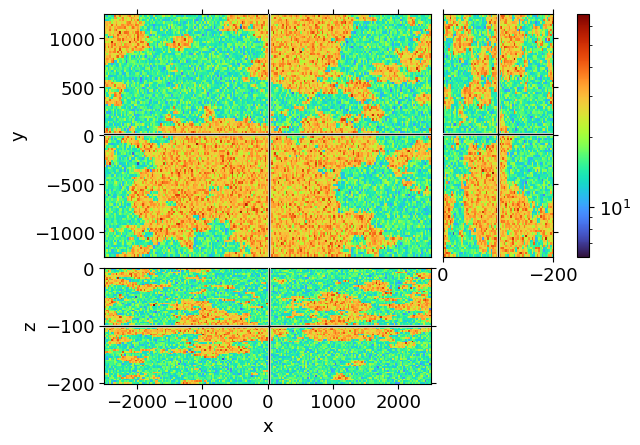

In [199]:
mesh.plot_3d_slicer(rho_sample, pcolor_opts={'cmap':'turbo', 'norm': LogNorm()})

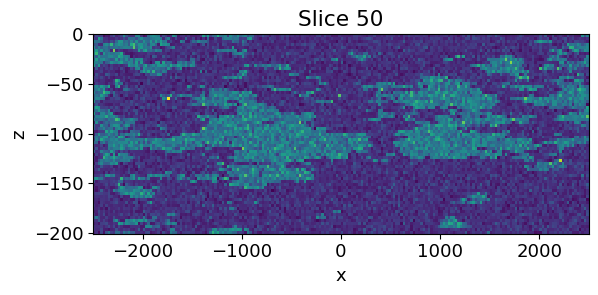

In [200]:
mesh.plot_slice(rho_sample, normal='Y')
plt.gca().set_aspect(10)